# Lecture: **Deep Learning with PyTorch**
## _Example problem to solve: image classification_

## 1. Package imports

In [4]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

## 2. Load images

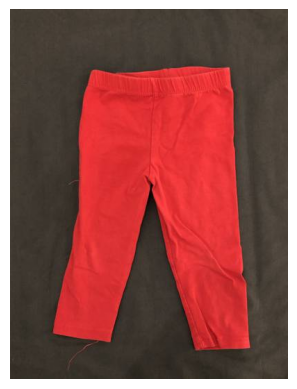

In [12]:
# Load an image
img = Image.open('data/clothing-dataset-small/train/pants/0a7e5fe0-d592-40e6-b9b8-75aac9a2d685.jpg')

# Helper to visualize an image
def show_image(img, show_axis=False):
    plt.imshow(img)
    if not show_axis:
        plt.axis('off')
        plt.show()

# Visualize the image img
show_image(img)

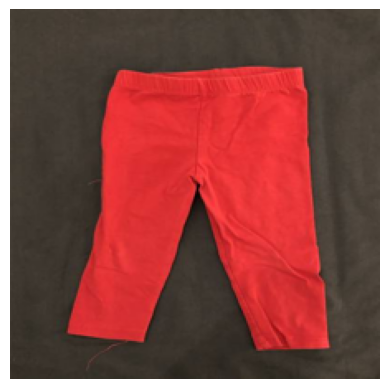

In [14]:
## Resize to target size
img = img.resize((224, 224))
show_image(img)

In [15]:
# Convert to a numpy array
x = np.array(img)
x.shape

(224, 224, 3)